# Classification using RNNs

We classify Roman Numbers with a label:
* 'first' if n < 5
* 'second' if n >= 5

In [19]:
import pandas as pd
import utils.neural_nets as nt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import torch
from roman_arabic_numerals import conv

In [5]:
data = pd.read_csv("data/roman-numbers/classification.csv")

In [6]:
# New labels for the dataset
def get_label(num):
    k = int(str(conv.rom_arab(num))[-1])
    if k < 5:
        return 'first'
    else:
        return 'second'

sequences = data.sequence.values
targets = data.target.values
vocabulary = set()
category_lines = {'first': [], 'second': []}
for i, seq in enumerate(sequences):
    n = seq.replace('_', '')
    for c in n:
        vocabulary.add(c)
    category_lines[get_label(n)].append(n)
vocabulary = sorted(list(vocabulary))
categories = list(category_lines.keys())

In [8]:
# Embedding of roman numbers as matrices
def num2tensor(num):
    tensor = torch.zeros(len(num), 1, len(vocabulary))
    for li, letter in enumerate(num):
        tensor[li][0][vocabulary.index(letter)] = 1
    return tensor

In [13]:
# Some utility functions

def read_categories(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return categories[category_i], category_i

def random_training_sample(embedding_function: callable):
    category = np.random.choice(categories)
    line = np.random.choice(category_lines[category])
    category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)
    line_tensor = embedding_function(line)
    return category, line, category_tensor, line_tensor

## Hand-Built RNN

### Training

In [10]:
input_size = len(vocabulary)
n_hidden = 32
output_size = len(categories)
rnn = nt.RNN(input_size, n_hidden, output_size)

In [14]:
history = rnn.run_training(
    data_generator=random_training_sample, # This generates the training samples from an embedding function
    embedding_function=num2tensor, # This is the embedding function for the dataset
    n_iterations=10000,
    plot_every=100
)

100%|██████████| 10000/10000 [00:22<00:00, 439.20it/s]


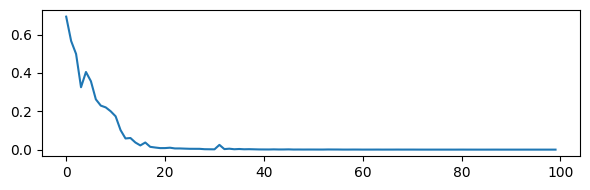

In [15]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
plt.tight_layout()
plt.show()

### Evaluation

In [20]:
n_test = 1000
y_true, y_pred = [], []
for i in range(n_test):
    category, line, category_tensor, line_tensor = random_training_sample(num2tensor)
    output = rnn.predict(line_tensor)
    predicted_label, predicted_index = read_categories(output)
    y_true.append(str(category))
    y_pred.append(str(predicted_label))

print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

       first       1.00      1.00      1.00       524
      second       1.00      1.00      1.00       476

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



## BOW (Bag-of-Words Model)

In [21]:
def num2bow(num):
    tensor = torch.zeros(1, len(vocabulary))
    for li, letter in enumerate(num):
        tensor[0][vocabulary.index(letter)] += 1
    return tensor

In [22]:
input_dim = len(vocabulary)
hidden_dim = 16
output_dim = len(categories)
learning_rate = 0.005
bow = nt.FrequencyPredictor(input_dim, hidden_dim, output_dim)

In [23]:
n_iterations = 10000
plot_every = 100
history = bow.run_training(
    data_generator=random_training_sample,
    embedding_function=num2bow, # A different embedding function
    n_iterations=10000,
    plot_every=100
)

100%|██████████| 10000/10000 [00:14<00:00, 712.17it/s]


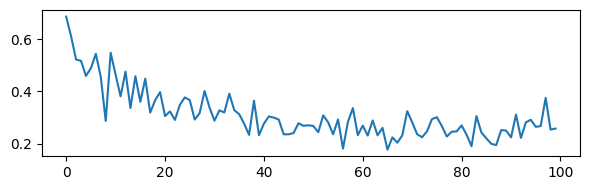

In [24]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
plt.tight_layout()
plt.show()

In [25]:
n_test = 1000
y_true, y_pred = [], []
for i in range(n_test):
    category, line, category_tensor, line_tensor = random_training_sample(num2bow)
    output = bow.predict(line_tensor)
    predicted_label, predicted_index = read_categories(output)
    y_true.append(str(category))
    y_pred.append(str(predicted_label))
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

       first       0.83      0.94      0.88       490
      second       0.94      0.81      0.87       510

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



## Fake RNN

It's a manual implementation of an RNN, where the h (the 'memory') is not passed from one iteration to the other

In [26]:
input_size = len(vocabulary)
n_hidden = 32
output_size = len(categories)
fake = nt.FakeRNN(input_size, n_hidden, output_size)

In [27]:
history = fake.run_training(
    data_generator=random_training_sample,
    embedding_function=num2tensor,
    n_iterations=10000,
    plot_every=100
)

100%|██████████| 10000/10000 [00:15<00:00, 649.07it/s]


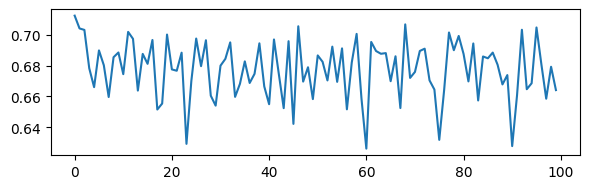

In [28]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
plt.tight_layout()
plt.show()

In [29]:
n_test = 1000
y_true, y_pred = [], []
for i in range(n_test):
    category, line, category_tensor, line_tensor = random_training_sample(num2tensor)
    output = fake.predict(line_tensor)
    predicted_label, predicted_index = read_categories(output)
    y_true.append(str(category))
    y_pred.append(str(predicted_label))
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

       first       0.54      0.24      0.34       495
      second       0.52      0.79      0.63       505

    accuracy                           0.52      1000
   macro avg       0.53      0.52      0.48      1000
weighted avg       0.53      0.52      0.48      1000



## Comparing Results

In [32]:
# Bag of words believes IV and VI are the same string
print("BOW")
with torch.no_grad():
    print(np.exp(bow(num2bow('VI')).numpy()))
    print(np.exp(bow(num2bow('IV')).numpy()))

# Fake RNN considers it to be a 50% chance (whether 4 or 6 are < 5)
print("\nFAKE")
with torch.no_grad():
    print(np.exp(fake.predict(num2tensor('IV')).numpy()))
    print(np.exp(fake.predict(num2tensor('VI')).numpy()))

# Real RNN has a much higher predicted value for the correct labels
# That is:
# VI ---> second (greater than 5)
# IV ---> first (less than 5)
print("\nRNN")
with torch.no_grad():
    print(np.exp(rnn.predict(num2tensor('VI')).numpy()))
    print(np.exp(rnn.predict(num2tensor('IV')).numpy()))

BOW
[[0.44050562 0.5594944 ]]
[[0.44050562 0.5594944 ]]

FAKE
[[0.5016201 0.4983799]]
[[0.47219813 0.52780193]]

RNN
[[6.3564585e-07 9.9999946e-01]]
[[9.9992085e-01 7.9157748e-05]]
